# Import stuff and set default parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from qutip import *
from functionsSqueeze import *
import seaborn as sns
import multiprocessing as mp

from platform import python_version

print(python_version())

3.6.9


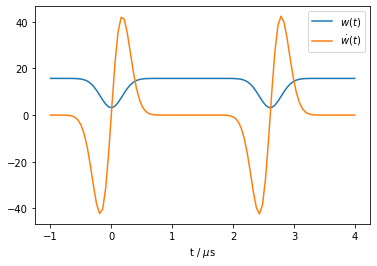

In [2]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-1, 4, 500) # 200 steps per mu s and 80 steps per T=0.4 mu s
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*0.93*w0, 0.18, 1.8098867063776491],
   'f0': 100/(9)}

argsQQ = {'n': n,
         'omega': wQQ,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': -0.8000325520833333*w0,
         'dt2': 0.18,
         'delay': 2*T+1.8108506944444442,
         'f0': 100/(9)}

ad = create(n)
a = destroy(n)
x = (ad + a)
p = 1j*(ad - a)

tlist = np.linspace(-1,4,100)
wDoubleQuench = wQQ(tlist, argsQQ)
wDoubleQuenchD = wQQdot(tlist, argsQQ)

plt.plot(tlist, wDoubleQuench, label="$w(t)$")
plt.plot(tlist, wDoubleQuenchD, label=r'$\dot{w}(t)$')
plt.legend()
plt.xlabel(r't / $\mu$s')
plt.show()

In [3]:
t1 = time.time()
resultQQ = eval_H_QQ(psi0, timesQQ, argsQQ)
print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 4.73 s


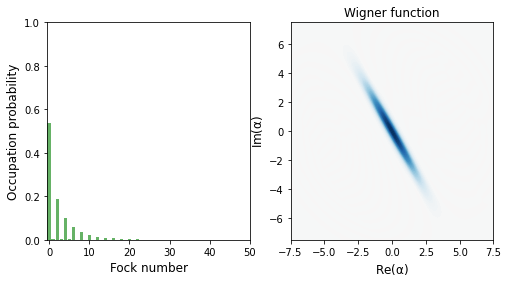

In [4]:
result = resultQQ
psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show()

alpha =  0.0013938608803536565 , xi =  (0.5772724604766382+1.089182221828883j)


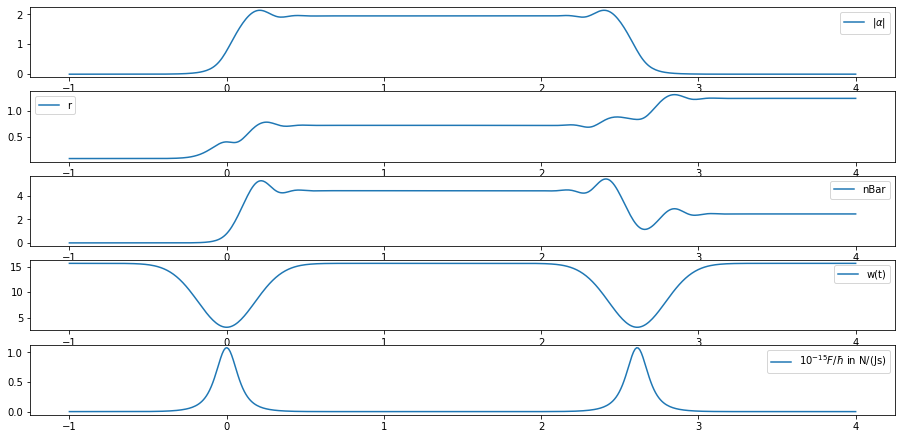

0

In [5]:
alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False, order_SD = True)
print("alpha = ", np.abs(alpha), ", xi = ", xi)

plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = False)

# evolution of $\alpha$ and $\xi$ in an undisturbed harmonic oscillator

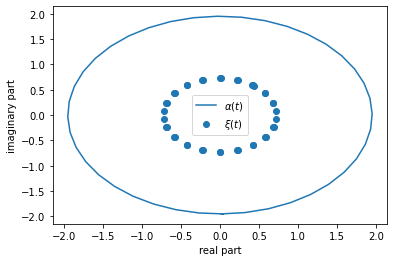

In [7]:
alphas = []
xis = []
for i in range(200, 241):
    alpha, xi,_,_ = getParams(result.states[i], calculate_nT = True)
    alphas.append(alpha)
    xis.append(xi)
    
plt.plot(np.real(alphas), np.imag(alphas), label = r'$\alpha(t)$')
plt.scatter(np.real(xis), np.imag(xis), label = r'$\xi(t)$')
plt.xlabel("real part")
plt.ylabel("imaginary part")
plt.legend()
plt.show()

look at the evolution of $\alpha$ after the first pulse <br/>
two things are intuitive: 1 $\alpha$ is constant, 2 $\alpha$ circles around 0 (with Period T)<br/>
in case 1: second pulse should look different from the first one <br/>
in case 2: both pulses should look the same, but $\alpha$ should be at the opposite position at the beginning of pulse 2<br/> <br/>
evaluate for this $\alpha$ (and $\xi$) during one period T (= 40 timesteps)<br/> <br/>
RESULT: alpha circles with Period T

0 x T / 8


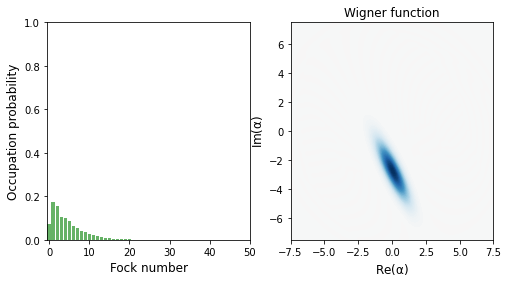

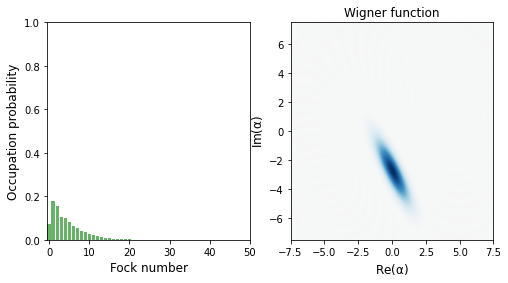

1 x T / 8


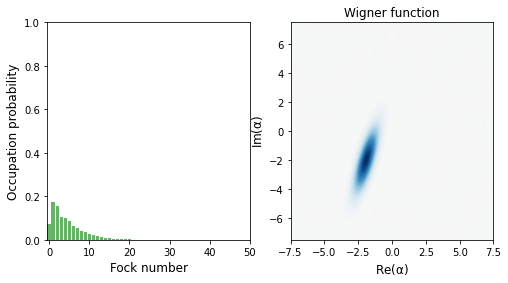

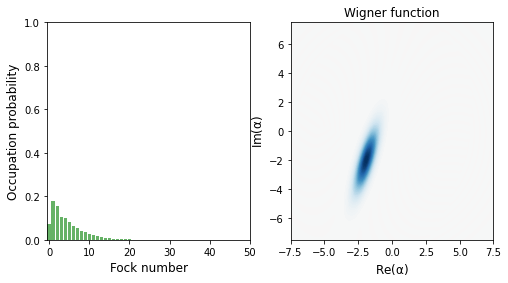

2 x T / 8


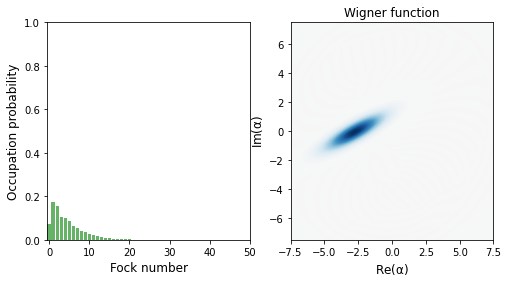

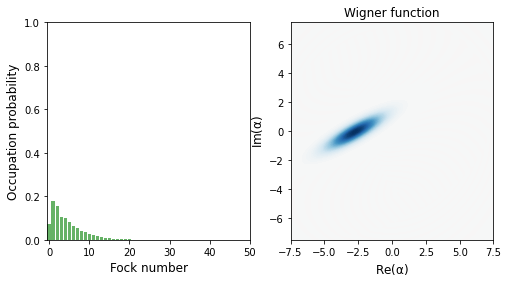

3 x T / 8


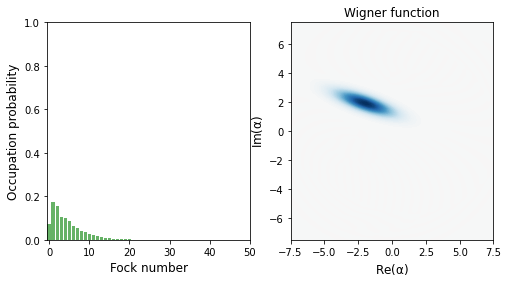

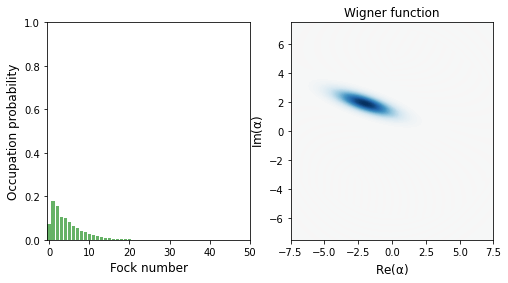

4 x T / 8


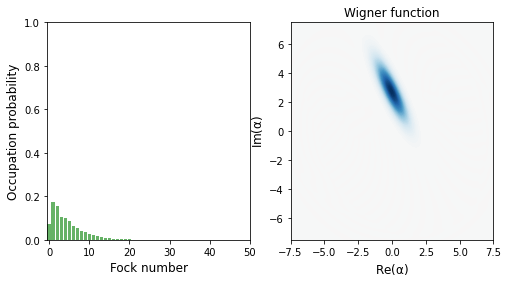

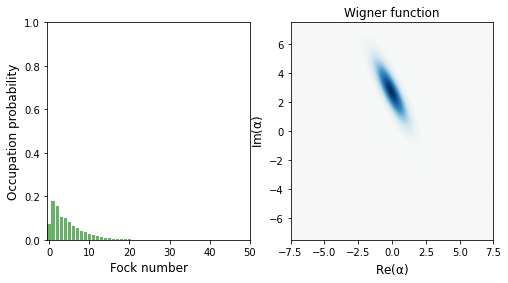

5 x T / 8


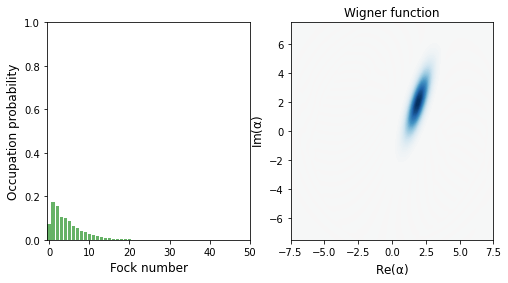

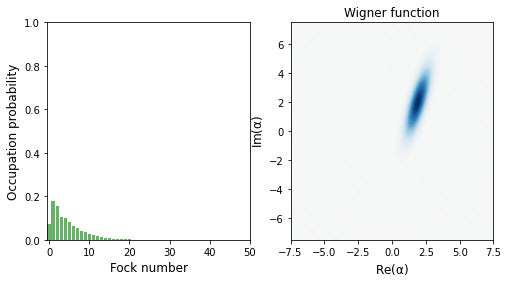

6 x T / 8


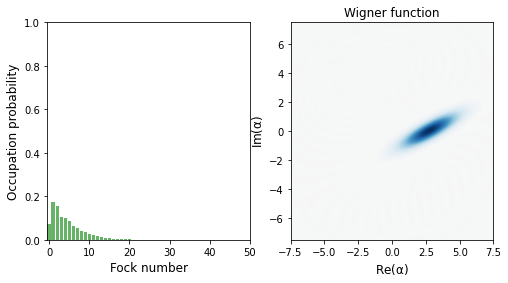

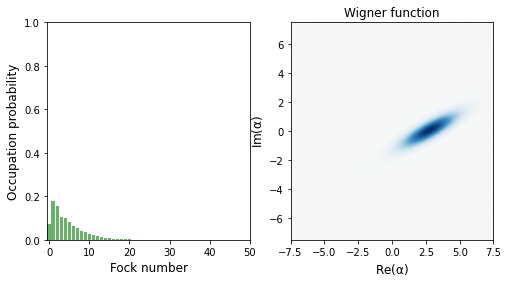

7 x T / 8


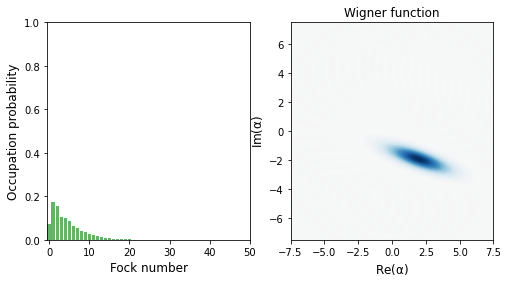

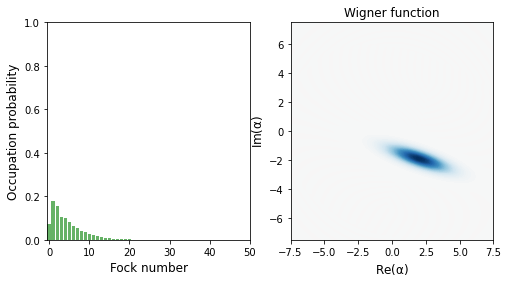

8 x T / 8


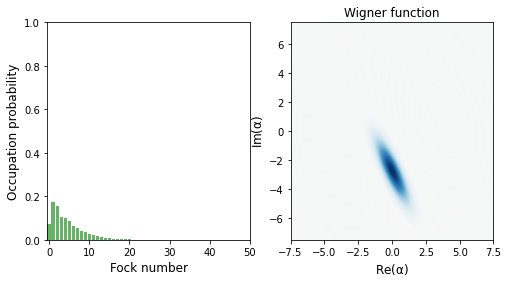

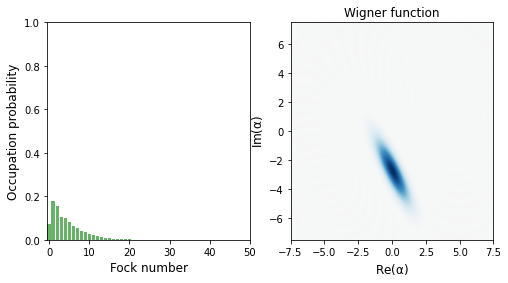

In [8]:
steps = 8

# get parameters of the initial state
alpha, xi, nBar, nT = getParams(result.states[200])
# print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)
# print('xi =', np.abs(xi), 'exp(i x', np.angle(xi), ')')

for i in range(steps + 1):
    print(i, "x T /", steps)
    psi = result.states[int(200 + i*40/steps)]
    plot_wigner_fock_distribution(psi)
    plt.show()
    
    xi1 = xi*np.exp(-2*i * 2*np.pi/steps*1j)
    alpha1 = alpha*np.exp(-i * 2*np.pi/steps*1j)
    psi1 = displace(n, alpha1)*squeeze(n, xi1)*thermal_dm(n, nT)*squeeze(n, xi1).dag()*displace(n, alpha1).dag()
    plot_wigner_fock_distribution(psi1)
    plt.show()

evolution of the wiegner function in an undisturbed harmonic oscillator for a squeezed coherent state during one period $T = 2 \pi/w_0$. The coherent displacement rotates (in the complex plane $\mathbb{C}$) with circular frequency $w_0$ whereas the squeezing parameter $\xi$ rotates with circular frequency $2w_0$.

# search the optimal delay between the two pulses and the optimal strength of the second pulse

In [44]:
n_delays = 10
n_dw2s = 10
t1 = time.time()

alphas = np.full((n_delays, n_dw2s), -1.)

delays = np.linspace(4*T, 5*T, n_delays)
dw2s = np.linspace(-0.9, -0.6, n_dw2s)

opt = Options()
opt.rhs_reuse = True
timesQQ = np.linspace(-1, 3, 401)

# loop over all possible combinations of delay, dw2
for i in range(n_delays):
    argsQQ['delay'] = delays[i]
    for j in range(n_dw2s):
        argsQQ['dw2'] = dw2s[j]*w0
        
        # evaluate time evolution and get alpha
        res = eval_H_QQ(psi0, timesQQ, argsQQ, options=opt)
        psi2 = res.states[-1]
        alpha = np.abs(expect(a, psi2))
        alphas[i, j] = alpha
    print('\r', "Progress:", round(100*(i)/n_delays), "%", end = '')
        
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 435.43 s


In [12]:
opt = Options()
opt.rhs_reuse = True

def get_alpha__delay_dw2(tp):
    delay = tp[0]
    dw2 = tp[1]
    argsQQ = {'n': n,
         'omega': wQQ,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': dw2*w0,
         'dt2': 0.18,
         'delay': delay,
         'f0': 100/(9)}
    
    # evaluate time evolution and get alpha
    res = eval_H_QQ(psi0, timesQQ, argsQQ, options=opt)
    psi2 = res.states[-1]
    return(np.abs(expect(a, psi2)))

In [3]:
n_delays = 10
n_dw2s = 10
t1 = time.time()

alphas = np.full((n_delays, n_dw2s), -1.)

delays = np.linspace(4*T, 5*T, n_delays)
dw2s = np.linspace(-0.9, -0.6, n_dw2s)

list_iter = []
list_id = []
for i in range(n_delays):
    for j in range(n_dw2s):
        list_iter.append([delays[i], dw2s[j]])
        list_id.append((i,j))


if __name__ == "__main__":
    pool = mp.Pool(mp.cpu_count())
    res_alphas = pool.map(get_alpha__delay_dw2, list_iter)


for i in range(len(res_alphas)):
    alphas[list_id[i]] = res_alphas[i]

print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 84.55 s


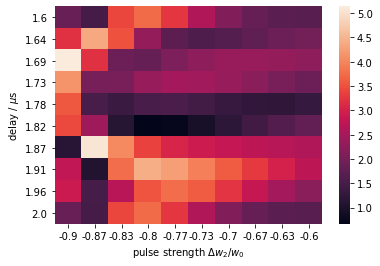

1.8222222222222222 -0.8


In [4]:
sns.heatmap(alphas, yticklabels = np.round(100*delays)/100, xticklabels = np.round(100*dw2s)/100 )
plt.ylabel(r'delay / $\mu$s')
plt.xlabel(r'pulse strength $\Delta w_2 / w_0$')
plt.show()

id_opt = np.unravel_index(np.argmin(alphas, axis=None), alphas.shape)
delay_opt = delays[id_opt[0]]
dw2_opt = dw2s[id_opt[1]]
print(delay_opt, dw2_opt)

 $|\alpha |$ for different delays and pulse strengs $\Delta w_2$<br/>
For different delays (covering one period T, large enough that the two pulses are well seperated) and strengths of the second pulse $\Delta w_2$ ranging from $-0.9\cdot w_0$ to $-0.6 \cdot w_0$, the absolute values of the coherent displacement of the final state are calculated. One can detect a few local minima, with the global minimum approximately in the middle of the heatmap.

In [13]:
# number of optimization steps
n_opt = 5
# size of square around optimal alpha, should be at least 3
n_sq = 5

t1 = time.time()
d_delays = delays[1]-delays[0]
d_dw2s = dw2s[1]-dw2s[0]

alphas_opt = np.full((n_sq, n_sq), -1.)

id_opt = np.unravel_index(np.argmin(alphas, axis=None), alphas.shape)
delay_opt = delays[id_opt[0]]
dw2_opt = dw2s[id_opt[1]]
alpha_opt_evolution = [alphas[id_opt]]

r_sq = (n_sq-1)/2
delays_opt = np.linspace(delays[id_opt[0]] - r_sq*d_delays/2., delays[id_opt[0]] + r_sq*d_delays/2., n_sq)
dw2s_opt = np.linspace(dw2s[id_opt[1]] - r_sq*d_dw2s/2., dw2s[id_opt[0]] + r_sq*d_dw2s/2., n_sq)

for ii in range(n_opt):
    # prepare the lists for delays, dw2s
    delays_opt = np.linspace(delay_opt - r_sq*d_delays/(2**(ii+1)), delay_opt + r_sq*d_delays/(2**(ii+1)), n_sq)
    dw2s_opt = np.linspace(dw2_opt - r_sq*d_dw2s/(2**(ii+1)), dw2_opt + r_sq*d_dw2s/(2**(ii+1)), n_sq)
    
    # loop over all possible combinations of delay, dw2
#    for i in range(3):
#        argsQQ['delay'] = delays_opt[i]
#        for j in range(3):
#            argsQQ['dw2'] = dw2s_opt[j]*w0

#            # evaluate time evolution and get alpha
#            res = eval_H_QQ(psi0, timesQQ, argsQQ, options=opt)
#            psi2 = res.states[-1]
#            alphas_opt[i, j] = np.abs(expect(a, psi2))
#     print('\r', "Progress:", round(100*(i)/n_delays), "%", end = '')
    
    list_iter = []
    list_id = []
    for i in range(n_sq):
        for j in range(n_sq):
            list_iter.append([delays_opt[i], dw2s_opt[j]])
            list_id.append((i,j))
            
    if __name__ == "__main__":
        pool = mp.Pool(mp.cpu_count()-1)
        res_alphas = pool.map(get_alpha__delay_dw2, list_iter)

    for i in range(len(res_alphas)):
        alphas_opt[list_id[i]] = res_alphas[i]
    
    print(np.round(alphas_opt, 4))
    # get next minimum
    id_opt = np.unravel_index(np.argmin(alphas_opt, axis=None), alphas_opt.shape)
    alpha_opt_evolution.append(alphas_opt[id_opt])
    delay_opt = delays_opt[id_opt[0]]
    dw2_opt = dw2s_opt[id_opt[1]]
    print(id_opt, delay_opt, dw2_opt)
    print("Progress:", round(100*(ii)/n_opt), "%")

print("processing time:", round(100*(time.time()-t1))/100, "s")

[[1.3524 1.4612 1.5371 1.5645 1.5535]
 [0.5985 0.547  0.5846 0.6218 0.6482]
 [1.1314 0.8145 0.6669 0.6533 0.7224]
 [2.5558 2.2303 2.0425 1.9483 1.9154]
 [4.0469 3.6498 3.3816 3.199  3.0731]]
(1, 1) 1.7999999999999998 -0.8166666666666667
Progress: 0 %
[[1.3524 1.4049 1.4612 1.5021 1.5371]
 [0.9696 1.0047 1.0416 1.08   1.105 ]
 [0.5985 0.5532 0.547  0.562  0.5846]
 [0.6094 0.4145 0.2544 0.1196 0.0156]
 [1.1314 0.9497 0.8145 0.7213 0.6669]]
(3, 4) 1.811111111111111 -0.8
Progress: 20 %
[[0.562  0.5732 0.5846 0.595  0.6045]
 [0.2806 0.2833 0.2922 0.3056 0.3218]
 [0.1196 0.0614 0.0156 0.05   0.0977]
 [0.3923 0.3579 0.336  0.3266 0.3285]
 [0.7213 0.6895 0.6669 0.6528 0.6464]]
(2, 2) 1.811111111111111 -0.8
Progress: 40 %
[[0.2833 0.2871 0.2922 0.2985 0.3056]
 [0.1358 0.1358 0.14   0.1478 0.1582]
 [0.0614 0.0348 0.0156 0.0268 0.05  ]
 [0.1984 0.184  0.1743 0.1696 0.1697]
 [0.3579 0.3454 0.336  0.3298 0.3266]]
(2, 2) 1.811111111111111 -0.8
Progress: 60 %
[[0.1358 0.1374 0.14   0.1435 0.1478]
 [0

In [9]:
np.round(alphas_opt, 4)

array([[1.692 , 1.8602, 2.0134, 2.1135, 2.1656, 2.1755, 2.1515],
       [1.2773, 1.3524, 1.4612, 1.5371, 1.5645, 1.5535, 1.513 ],
       [0.9173, 0.5985, 0.547 , 0.5846, 0.6218, 0.6482, 0.6723],
       [1.6528, 1.1314, 0.8145, 0.6669, 0.6533, 0.7224, 0.8302],
       [3.0701, 2.5558, 2.2303, 2.0425, 1.9483, 1.9154, 1.9213],
       [4.6219, 4.0469, 3.6498, 3.3816, 3.199 , 3.0731, 2.9846],
       [5.3788, 5.2788, 4.8673, 4.5167, 4.2392, 4.0161, 3.8311]])

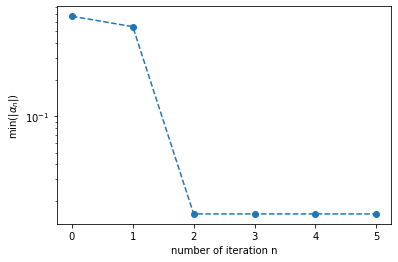

In [11]:
plt.semilogy(np.arange(n_opt+1), alpha_opt_evolution, 'o--')
plt.xlabel("number of iteration n")
plt.ylabel(r'$\min(|\alpha_n |)$')
plt.show()

Evolution of $|\alpha |$ during the minimization process.<br/>
Starting from the global minimum above, the bisection method is used to minimite $|\alpha |$ further, using 10 iterations.

## find Minimum, als, kann eigentlich weg

In [129]:
# checking how |alpha| behaves when the delay is changed through 1 period T 
delayS = np.linspace(4*T, 5*T, 37) # at least 4T
alphaF = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
for dt in delayS:
    times2 = np.linspace(2*T, 3, 200)
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress:", round(100*(dt-delayS[0])/(delayS[-1]-delayS[0])), "%", end = '')

 Progress: 4.0 %%

In [22]:
# calculate time evolution over first quench and get final alpha
resultQQ = mesolve(H, psi0, np.linspace(-1, 2*T, 181), args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

In [3]:
# calculate time evolution over second quench for all values in dalayS
delayS = np.linspace(4*T, 5*T, 5)
timesS = np.linspace(-1, 3, 401)
psi0 = thermal_dm(n, 0.01)

alphaF,_,_ = scanAlphaXiN(H, psi0, timesS, argsQQ, delayS, -1, skippInLoop = 180)

 Progress:  100.0 %, processing time: 233 s

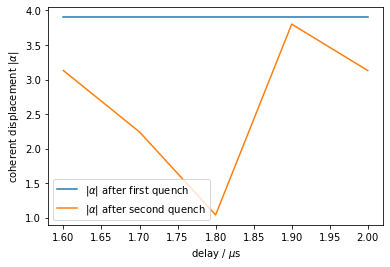

1.7751539513788734


In [23]:
# fit a quadratic polynom on the minimum to get a more exact position
def fitFkt(x, a, b, c):
    return(a*x**2 + b*x + c)

# take two points left and right of the minimum for the quadratic fit
alphaF = np.abs(alphaF)
idx = np.argmin(alphaF)
# idx = alphaF.index(min(alphaF))
xFit = delayS[idx-2:idx+3]
yFit = alphaF[idx-2:idx+3]
params,_ = optimize.curve_fit(fitFkt, xFit, yFit, p0 = [0, 0, 0]) # do the fit

# plot the results from above
plt.plot([delayS[0], delayS[-1]], [np.abs(alpha1), np.abs(alpha1)], label = r'$|\alpha |$ after first quench')
plt.plot(delayS, alphaF, label = r'$|\alpha |$ after second quench')

# plot the fit
# xlist = np.linspace(xFit[0]-0.03, xFit[-1]+0.03, 1000)
# plt.plot(xlist, fitFkt(xlist, params[0], params[1], params[2]), label = "quadratic fit around the minimum")
# plt.scatter(xFit, yFit, label = "points taken for the quadratic fit")
plt.legend()
plt.xlabel(r'delay / $\mu$s')
plt.ylabel(r'coherent displacement $|\alpha |$')
plt.show()

delayOpt = -params[1]/(2*params[0])
print(delayOpt)

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T \in \left[4T, 5T\right]$ (with T = 0.4 $\mu s$ the period of the unpertubed signal) between the two pulses. A minimum is visible in the first half of the peiod.

In [122]:
# check if the number off full periods T between the two quenches plays a role (result: No)
delays = np.linspace(delayOpt, delayOpt + 12*T, 13) # at least 4T
alphaF2 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha12,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
i = 0
for dt in delays:
    times2 = np.linspace(2*T, dt + 2*T, 200+50*i) # keep spacing the same
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alphaF2.append(np.abs(alpha2)) # save alpha
    i += 1
    print('\r', "Progress: ", round(100*(dt-delays[0])/(delays[-1]-delays[0])), " %", end = '')

 Progress:  100.0  %

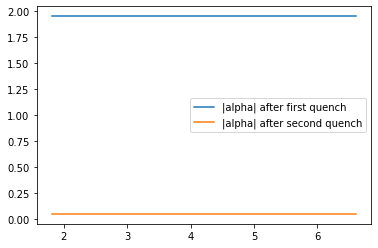

In [123]:
plt.plot([delays[0], delays[-1]], [np.abs(alpha12), np.abs(alpha12)], label = "|alpha| after first quench")
plt.plot(delays, alphaF2, label = "|alpha| after second quench")
plt.legend()
plt.show()

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T = t_0 + n \cdot T$ (with T = 0.4 $\mu s$ the period of the unpertubed signal, $t_0$ at the minimum from figure above, $n \in \{0, 1, 2, \dots, 12\}$) between the two pulses. No dependance on $n$ is visible.

In [35]:
# check the influence of the second quenches strength (=> should be the same as the first one)
# make sure to use the optimal delay (see above)

dw2s = np.linspace(-0.9, -0.5, 41)
alphaF3 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
# alpha13,_,_,_ = getParams(psi1, False)
alpha13 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2s:
    argsQQ['omegaArgs'][3] = dw2*w0 # only change the secon pule strength in argsQQ    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

    psi2 = resultQQ.states[-1] # final state
#     alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF3.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress: ", round(100*(dw2-dw2s[0])/(dw2s[-1]-dw2s[0])), " %", end = '')

 Progress:  100.0  %

In [37]:
# check the influence of the second quenches strength (=> should close to the first one)
# make a better search around the minimum from above
# make sure to use the optimal delay (see above)

dw2Opt = dw2s[alphaF3.index(min(alphaF3))]

dw2sexact = np.linspace(dw2Opt-0.01, dw2Opt+0.01, 21) # 0.01 is the stepsize above
alphaF3exact = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
# alpha13,_,_,_ = getParams(psi1, False)
# alpha13 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2sexact:
    argsQQ['omegaArgs'][3] = dw2*w0 # only change the secon pule strength in argsQQ    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

    psi2 = resultQQ.states[-1] # final state
#     alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF3exact.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress: ", round(100*(dw2-dw2sexact[0])/(dw2sexact[-1]-dw2sexact[0])), " %", end = '')

 Progress:  100.0  %

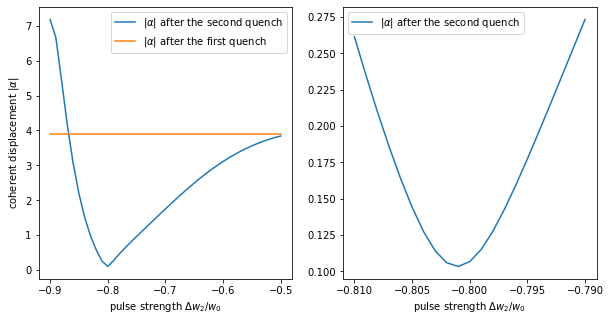

-0.801


In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)
ax1.plot(dw2s, alphaF3, label = r'$|\alpha|$ after the second quench')
ax1.plot([dw2s[0], dw2s[-1]], [np.abs(alpha13), np.abs(alpha13)], label = r'$|\alpha|$ after the first quench')
ax1.legend()
ax1.set(xlabel=r'pulse strength $\Delta w_2 / w_0$', ylabel=r'coherent displacement $|\alpha |$')

ax2.plot(dw2sexact, alphaF3exact, label = r'$|\alpha|$ after the second quench')
ax2.legend()
ax2.set(xlabel=r'pulse strength $\Delta w_2 / w_0$')
plt.show()

dw2Optexact = dw2sexact[alphaF3exact.index(min(alphaF3exact))]
print(dw2Optexact)

coherent displacement for different strengths of the second pulse <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for different strengths of the second pulse $\Delta w_2 = \gamma \cdot w_0$ (with $w_0 = 2\pi \cdot 2.5$ MHz the unperturbed circular frequency, $\gamma \in \left[-0.9, -0.3\right]$). A minimum is at the position $\Delta w_2 = 0.8 \cdot w_0 = \Delta w_1$ which corresponds to the strength of the first pulse.

In [ ]:
# do a grid search around the minimum found
delayOpt = 1.8099751290225832
dw2Opt = -0.8

delaysg = np.linspace(delayOpt - 0.005, delayOpt + 0.01, 4) # Stepsize is 0.005, above it was 0.01
dw2sg = np.linspace(dw2Opt - 0.02, dw2Opt + 0.04, 4) # same stepsize as above
alphaFg = []
paramsListg = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1g,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dt in delaysg:
    for dw2 in dw2sg:
        argsQQ['omegaArgs'][3] = dw2*w0
        argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
        resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

        psi2 = resultQQ.states[-1] # final state
        alpha2g,_,_,_ = getParams(psi2, False) # get alpha
        alphaFg.append(np.abs(alpha2g)) # save alpha
        paramsListg.append([dt, dw2])
        print('\r', "Progress dt:", round(100*(dt-delaysg[0])/(delaysg[-1]-delaysg[0])), "%, Progress dw:", round(100*(dw2-dw2sg[0])/(dw2sg[-1]-dw2sg[0])), " %",end = '')

In [ ]:
idxg = alphaFg.index(min(alphaFg))
print(alphaFg[idxg], paramsListg[idxg])

# Theoretical calculations on the quenching operator
## Assume the quench operator can be written as an infinite product of identical infinitesimal squeezing and displacement operators

in this section, I try to reproduce predictions from theoretical considerations concerning the quenching operator $Q$<br/>
First I assume $Q$ can be written as infinite series of squeezing operator after displaysment operator, which leads to not so good results (both theoretical and then the calculation of these predictions)<br/>
Second I assume $Q = D(\alpha) S(\xi)$, which leads to nice results

|alpha|= 1.9089449058305008 , xi = 0.7445947082638125 , nBar = 4.308834591727924 , nT = 5.918334664173196e-07
|alpha|= 0.2976376100100826 , xi = 1.0052068442190116 , nBar = 1.4886728301574919 , nT = 5.925227628495373e-07


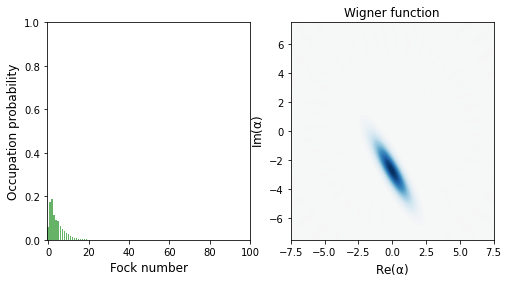

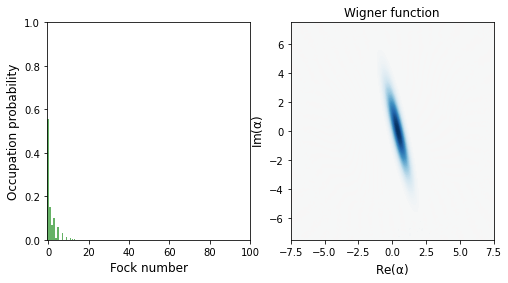

In [6]:
n = 100

# parameters for free evolution between two quenches
phi = -0.37
timesNix = np.linspace(0, phi*T, 100)
argsNix = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, 0, 0.18, 0, 0, 0.],
       'f0': 0}

xi0 = 0.34839 +0.658062j
alpha0 = -0.0190384 -1.90885j

# initial state
psi0 = fock_dm(n, 0)

# state after first quench
psi1 = displace(n, alpha0)*squeeze(n, xi0) *psi0* squeeze(n, xi0).dag()*displace(n, alpha0).dag()
plot_wigner_fock_distribution(psi1)

# state after first quench and free evolution between the two quenches
resultNix = mesolve(H, psi1, timesNix, args=argsNix)
psi2 = resultNix.states[-1]

# state after second quench
xi1 = 0.264464 +0.499537j
alpha1 = -0.265918 -1.1022j
psi3 = displace(n, alpha1)*squeeze(n, xi1) *psi2* squeeze(n, xi1).dag()*displace(n, alpha1).dag()
plot_wigner_fock_distribution(psi3)

# alpha, xi, nBar, nT = getParams(psi1)
# print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)
alpha, xi, nBar, nT = getParams(psi2)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)
alpha, xi, nBar, nT = getParams(psi3)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)

State after a fist and second quench operator.<br/>
Assuming the quenching can be written as an infinite product of identical infinitesimal squeezing and displacement, the upper picture shows the state after the first quench. The lower picture shows the state after a free evolution of length $t$ and a second quench with reduced strength $\gamma$, both $\gamma$ and $t$ are calculated to minimize the final coherent displacement, which is in the final state approximately 10% of the first state, so much reduced but still much higher than the calculated final displacement of $|\alpha | = 0.039$.

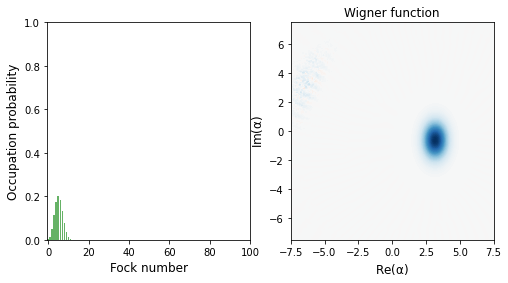

|alpha|= 2.2947736231222002 , xi = 0.18355898255090858 , nBar = 5.3000600119520485 , nT = 1.7828858415156836e-07


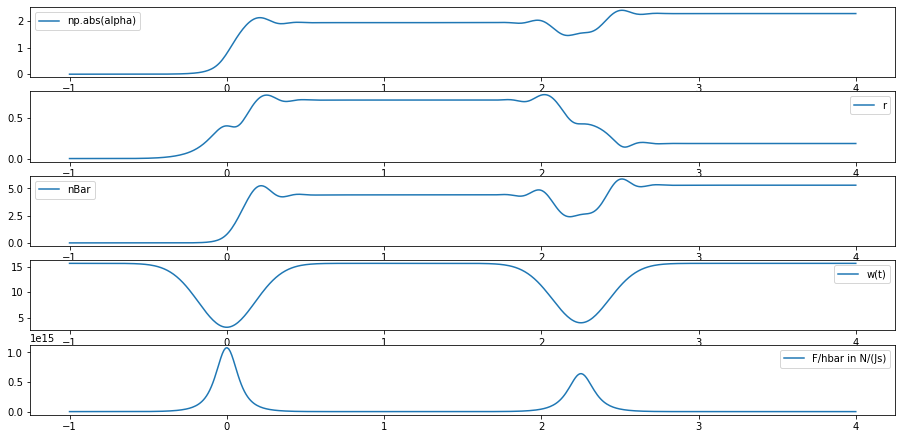

0

In [8]:
# do the corresponding double quench sequence
n = 50
timesQQ = np.linspace(-1, 4, 500) # 200 steps per mu s and 80 steps per T=0.4 mu s
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*0.93*w0, 0.18, 2 + (1+phi)*T],
   'f0': 100/(9*10**-15)}

psi0 = fock_dm(n, 0)
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)
psiQQ = resultQQ.states[-1]

plot_wigner_fock_distribution(psiQQ)
plt.show()

alpha, xi, nBar, nT = getParams(psiQQ)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)

plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = False)

Doing the two quenches explicitly, with the values for the delay between them and their strengths taken from theoretical calculations (see above and mathematica).<br/>
The final state has a quite large coherent displacement, thus leads to the conclusion that a quench cannot be described as an infinite product of identical infinitesimal squeezing and displacement operators.

## Assume the quenching can be written as the producto of one squeezing and one displacement operator: $Q = D(\alpha) S(\xi)$

In [9]:
n = 50
dt = 0.643368
deltaT = -2*np.pi*1j*dt/T
alpha1 = (-0.0190384 - 1.90885j)*np.exp(deltaT)
alpha2 = -0.158869 - 1.53141j
xi1 = (0.34839 + 0.658062j)*np.exp(2*deltaT)
xi2 = 0.311284 + 0.587975j

opQ = displace(n, alpha1)*squeeze(n, xi1)
opQQ = displace(n, alpha2)*squeeze(n, xi2)*displace(n, alpha1)*squeeze(n, xi1)

|alpha|= (1.2168736120218722+1.470809782774125j) , xi = (0.723236528349471-0.2185430788380217j) , nBar = 4.332129000836538 , nT = 0.010378671485756252
|alpha|= (0.0014268082639255428-0.00026107980862309903j) , xi = (0.9236364436047847+0.7701406413715267j) , nBar = 2.2927963167713767 , nT = 0.018011835338001436


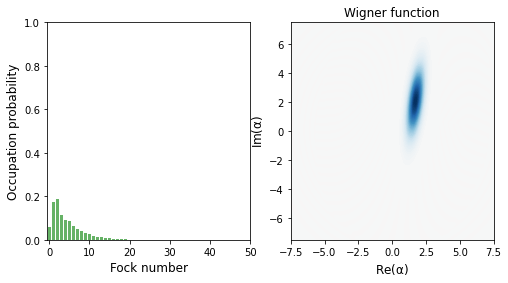

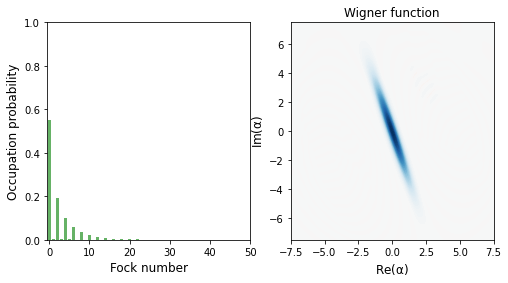

In [10]:
psi1 = opQ*thermal_dm(n, 0.01)*opQ.dag()
psi2 = opQQ*thermal_dm(n, 0.01)*opQQ.dag()

alpha, xi, nBar, nT = getParams(psi1)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

alpha, xi, nBar, nT = getParams(psi2)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

plot_wigner_fock_distribution(psi1)
plt.show()
plot_wigner_fock_distribution(psi2)
plt.show()

State after the action $Q_2 R(t) Q_1$ of two quench operators $Q_1 = D(\alpha(1)) S(\xi(1))$, $Q_2 = D(\alpha(\gamma)) S(\xi(\gamma))$, with $\alpha(\gamma)$ and $\xi(\gamma)$ functions of the pulse strength relative to the first pulse strength $\gamma$ (see fits in the squeezed file), $R(t)$ evolution of the state for time $t$ in the undisturbed harmonic oscillator. Values for $\gamma$ and $t$ are taken from theoretical calculations (see mathematica, section "Now assume $Q = D(\alpha) S(\xi)$") for minimal coherent displacement.<br/>
Since the state obtained (2nd pair of plots) has quite small coherent displacement (especially with respect to the state after the first quench (first pair of plots)), it shows that the calculations are not too bad.

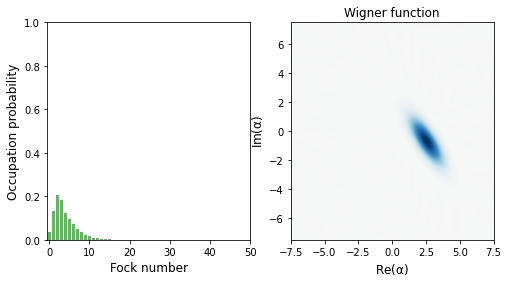

|alpha|= 1.8682550904131798 , xi = 0.552885198790719 , nBar = 3.8285045906846187 , nT = 4.9281981384188166e-05


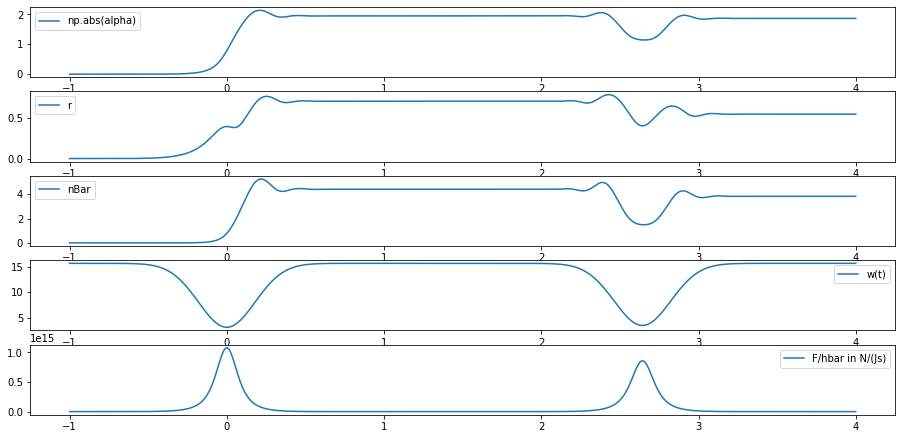

0

In [13]:
# do the corresponding double quench sequence
timesQQ = np.linspace(-1, 4, 500)
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*0.971169*w0, 0.18, 2 + dt],
   'f0': 100/(9*10**-15)}

psi0 = fock_dm(n, 0)
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)
psiQQ = resultQQ.states[-1]

plot_wigner_fock_distribution(psiQQ)
plt.show()

alpha, xi, nBar, nT = getParams(psiQQ)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)

plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = False)

Doing the two quenches explicitly, with the values for the delay between them and their strengths taken from theoretical calculations (see above and mathematica).<br/>
The final state has a quite large coherent displacement, thus leads to the conclusion that a quench cannot be described as  $Q = D(\alpha) S(\xi)$, or that I made some fatal error.